# Image Analysis met Python
## BINN, 2023
### Quinten Plevier

Deze notebook is bedoeld om uitgevoerd te worden in Google Colab. Hoogste score behaald in de les was ~89%.

Importeren van de nodige modules.

In [1]:
import os
from skimage import io
import shutil
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout
from keras.models import Model, Sequential
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

In Google Colab is het mogelijk om een GPU te gebruiken voor het trainen van het neurale netwerk. Dit is veel sneller dan trainen op een CPU. Om het zo consisten mogelijk te houden, is er voor gekozen om deze opdracht te maken in Google Colab. Het is nodig om deze te linken aan je Google Drive om de bestanden (de foto's voor het trainen) in je Drive te gebruiken.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Code voor het croppen en toepassen van de median_filter op elke afbeelding. Croppen wordt gedaan zodat de verhoudingen van de afbeelding gelijk blijven wanneer deze geresized worden in een latere stap. De median filter wordt toegepast om de oneffenheden uit de afbeelding te halen voor betere classificatie.

In [3]:
def crop_median(indir, outdir, median):
    half = 260
    for dir in os.listdir(indir):
        if os.path.isdir(os.path.join(indir, dir)):
            for file in os.listdir(os.path.join(indir, dir)):
                iofile = io.imread(os.path.join(indir, dir, file))
                y, x = np.nonzero(iofile)
                leftmost = x.min()
                rightmost = x.max()
                middle = round((leftmost + rightmost) / 2)
                if middle < half:
                    cutoffleft = 0
                    cutoffright = 520
                elif middle > 696 - half:
                    cutoffleft = 176
                    cutoffright = 696
                else:
                    cutoffleft = middle - half
                    cutoffright = middle + half
                outfile = iofile[0:520, cutoffleft:cutoffright]
                if median:
                    outfile = median_filter(outfile, 5)
                io.imsave(os.path.join(outdir, dir, f"crop_{file}"), outfile, check_contrast=False)

De directories met alle afbeeldingen. De *out* directories worden eerst verwijderd en opnieuw aangemaakt. Deze worden vervolgens gevuld met de gecroppede en median filtered afbeeldingen.

In [4]:
indir = "/content/drive/MyDrive/wormen/wormen_split"
outdir = "/content/drive/MyDrive/wormen/cropped"
test_dir = "/content/drive/MyDrive/wormen/wormen_split_test"
test_outdir = "/content/drive/MyDrive/wormen/cropped_test"

if os.path.isdir(outdir):
    shutil.rmtree(outdir)
os.mkdir(outdir)
os.mkdir(os.path.join(outdir, "dood"))
os.mkdir(os.path.join(outdir, "levend"))

if os.path.isdir(test_outdir):
    shutil.rmtree(test_outdir)
os.mkdir(test_outdir)
os.mkdir(os.path.join(test_outdir, "dood"))
os.mkdir(os.path.join(test_outdir, "levend"))

crop_median(indir, outdir, True)
crop_median(test_dir, test_outdir, True)

Variabelen inladen voor het ophalen van de datasets.

In [5]:
data_dir = outdir
test_dir = test_outdir

batch_size = 32
img_height = 520
img_width = 520
image_size = (img_height, img_width)

Inladen van de training en validatie dataset. Ook worden de class_names opgehaald (["dood", "levend"]).

In [6]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    color_mode="rgb",
    subset="both",
    validation_split= 0.2,
    shuffle=True,
    seed=1,
    image_size=image_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    color_mode="rgb",
    shuffle=True,
    seed=1,
    image_size=image_size,
    batch_size=batch_size
)

class_names = train_ds.class_names

Found 1055 files belonging to 2 classes.
Using 844 files for training.
Using 211 files for validation.
Found 352 files belonging to 2 classes.


De afbeeldingen hebben een grootte van 520 pixels wijd bij 520 pixels hoog. Het neurale netwerk neemt 224 pixels bij 224 pixels als input, dus deze moeten eerst geresized worden.

In [7]:
size = (224, 224)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

De foto's in de dataset die worden meegegeven aan deze functie worden 'geaugmenteerd'. Data augmentatie is erg belangrijk wanneer er niet heel veel trainingfoto's zijn. De foto's worden random gespiegeld, gedraaid en gezoomd.

In [8]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2)
    ]
)

Hier worden de datasets voorbereid voor het trainen, valideren en testen. De trainingdataset wordt gekopieerd naar een tweede trainingdataset en meteen geaugmenteerd. De twee trainingdatasets worden samengevoegd tot één dataset. Daarna worden ze gecached en prefetched zodat deze sneller gebruikt kunnen worden voor gebruikt bij het model.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds2 = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=AUTOTUNE,
)

train_ds = train_ds.concatenate(train_ds2)

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Dit is het neurale netwerk. VGG16 is een pretrained model waarop de code er onder is uitgebreid. De dropout is toegevoegd om overfitting tegen te gaan. Voor binaire classificatie (classificatie in 2 classes) wordt de sigmoid activatie gebruikt, omdat het gaat om een kansvoorspelling dat het één van de twee classes is.

In [10]:
def vgg16_model():
    model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))
    x = Dense(1024, activation="relu")(model.layers[-4].output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(model.input,x)
    return model

model = vgg16_model()

553467096/553467096 [==============================] - 17s 0us/step


Met compile wordt de configuratie van het model ingesteld.

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

Fit is de functie om het model te trainen met de trainingdataset. Het aantal epochs zijn de iteraties die het model doet over de gehele dataset. De validatiedataset wordt gebruikt om de validatie loss en metrics te monitoren aan het eind van elke epoch.

In [12]:
history = model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds
)

Epoch 1/5
54/54 [==============================] - 55s 619ms/step - loss: 0.8139 - accuracy: 0.6037 - val_loss: 0.5464 - val_accuracy: 0.7583
Epoch 2/5
54/54 [==============================] - 20s 371ms/step - loss: 0.4515 - accuracy: 0.8081 - val_loss: 0.4473 - val_accuracy: 0.8057
Epoch 3/5
54/54 [==============================] - 20s 373ms/step - loss: 0.3960 - accuracy: 0.8341 - val_loss: 0.4303 - val_accuracy: 0.8389
Epoch 4/5
54/54 [==============================] - 20s 376ms/step - loss: 0.3644 - accuracy: 0.8495 - val_loss: 0.4425 - val_accuracy: 0.8152
Epoch 5/5
54/54 [==============================] - 21s 387ms/step - loss: 0.3271 - accuracy: 0.8572 - val_loss: 0.4584 - val_accuracy: 0.8578


De testdataset wordt gebruikt om de classificatie te voorspellen tegen het model.

In [13]:
predictions = model.predict(test_ds, batch_size=batch_size)

11/11 [==============================] - 3s 126ms/step


De functies om de testdataset visueel te weergeven. Hierin wordt de foto weergeven naast een barplot met de confidences voor de klasses waarin deze afbeelding is geclassificeerd. Ook wordt hier bijgehouden hoeveel true-positives/negatives en false-positives/negatives er zijn. Deze worden later geplot in de confusionmatrix. Bij een voorspelling **kleiner dan** 0.5 is de worm dood voorspeld. Bij een voorspelling **groter dan** 0.5 is de worm levend voorspeld.

In [14]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array = np.append(predictions_array, [1-predictions_array])
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.astype(np.uint8))
    if predictions_array[0] < 0.5:
        predicted_label = 0
    else:
        predicted_label = 1
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}%\nTrue: {}".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

true_dood, false_dood, true_levend, false_levend = 0, 0, 0, 0

def plot_value_array(i, predictions_array, true_label):
    global true_dood, false_dood, true_levend, false_levend
    true_label = true_label[i]
    predictions_array = np.append([1-predictions_array], predictions_array)
    plt.grid(False)
    plt.xticks(range(2))
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    if predictions_array[0] < 0.5:
        predicted_label = 1
    else:
        predicted_label = 0

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

    if predicted_label == true_label and predicted_label == 0:
        true_dood += 1
    elif predicted_label == true_label and predicted_label == 1:
        true_levend += 1
    elif predicted_label != true_label and predicted_label == 0:
        false_dood += 1
    elif predicted_label != true_label and predicted_label == 1:
        false_levend += 1

De foto's en labels uit de testdataset worden opgeslagen. Er wordt dynamisch een plot gemaakt voor het aantal foto's in de testdataset (bij veel foto's kan dit wat trager worden).

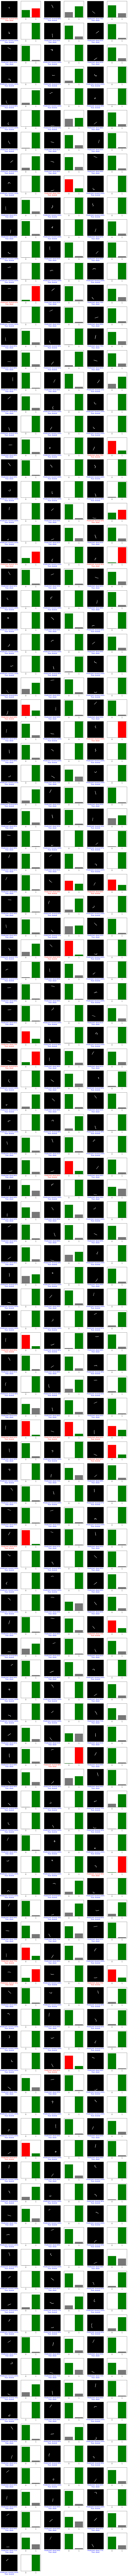

In [15]:
test_images = np.concatenate([x for x, y in test_ds], axis=0)
test_labels = np.concatenate([y for x, y in test_ds], axis=0)

num_images = len(predictions)
num_cols = 3
num_rows = num_images // num_cols

if num_images % num_cols != 0:
    num_rows += 1

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

De confusion matrix functie van Tensorflow kreeg ik niet aan de praat dus heb ik dat zelf gemaakt (veel mooier vind ik zelf ;)). Daaronder is ook de accuracy van het model weergeven.

In [16]:
## EIGEN CONFUSION MATRIX
print("VOORSPELD")
print("Levend | Dood   | WAARHEID")
print(f"-------+--------|")
print(f"{true_levend:6} | {false_dood:<6} | Levend")
print(f"-------+--------|")
print(f"{false_levend:6} | {true_dood:<6} | Dood")

result = model.evaluate(test_ds, verbose=0)
print(f"\nAccuracy:\n{result[1]*100:.2f}%")

VOORSPELD
Levend | Dood   | WAARHEID
-------+--------|
   173 | 19     | Levend
-------+--------|
    10 | 150    | Dood

Accuracy:
91.76%


Bij het testen van de afbeeldingen waren scores behaald tussen de 87.5% en 89.8%. Niet elke afbeelding kan wordt dus goed voospeld, maar wel een erg groot deel. In de data zitten afbeeldingen die niet heel goed zijn voor het voorspellen, zoals levende wormen die in de afbeelding (een tijdsopname) recht liggen. Deze zullen vaak als dood worden voorspeld. Voor het verder testen van de kwaliteit van het neural network kunnen deze foto's met "verkeerde" labels er uit gehaald worden. Nadat dit is gedaan kan de maximale potentie van het model worden berekend.

Als er nog vragen zijn of er werkt ineens iets niet meer, laat het me dan vooral weten!